# Data preprocessing

In [ ]:
import json

# Mount Google Drive to access data
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/Colab Notebooks/data_cged/training_data.jsonl'

# Load the data and create pairs directly
def load_data_and_create_pairs(file_path):
    sentence_pairs = []

    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            item = json.loads(line.strip())
            # Check if both correct and error fields are present and not empty
            if item.get("correct") and item.get("error"):
                correct_item = {"sentence": item["correct"], "label": 1}
                ungrammatical_item = {"sentence": item["text"], "label": -1}
                sentence_pairs.append((correct_item, ungrammatical_item))

    return sentence_pairs

sentence_pairs = load_data_and_create_pairs(file_path)

print(f"Created {len(sentence_pairs)} sentence pairs from original data.")
print(sentence_pairs[1], sentence_pairs[5], sentence_pairs[10])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Created 41490 sentence pairs from original data.
({'sentence': '那下次见吧。', 'label': 1}, {'sentence': '那下次见面吧。', 'label': -1}) ({'sentence': '虽然我不能去但是他们都去。', 'label': 1}, {'sentence': '虽然我不能去但是别人他们都去。', 'label': -1}) ({'sentence': '他们都有很好的一天。', 'label': 1}, {'sentence': '他们都有很好的天。', 'label': -1})


In [ ]:
# 80-10-10 split
from sklearn.model_selection import train_test_split

train_pairs, temp_pairs = train_test_split(sentence_pairs, test_size=0.2, random_state=42)
val_pairs, test_pairs = train_test_split(temp_pairs, test_size=0.5, random_state=42)

print(f"Number of pairs in training set: {len(train_pairs)}")
print(f"Number of pairs in validation set: {len(val_pairs)}")
print(f"Number of pairs in test set: {len(test_pairs)}")

# Inspect a few pairs from each set
print("\nExamples from training set:")
print(train_pairs[:2])

print("\nExamples from validation set:")
print(val_pairs[:2])

print("\nExamples from test set:")
print(test_pairs[:2])

Number of pairs in training set: 33192
Number of pairs in validation set: 4149
Number of pairs in test set: 4149

Examples from training set:
[({'sentence': '吸烟包括吸烟者自己对吸烟者旁边的人有影响，比如说：癌症、记忆力衰弱等等。', 'label': 1}, {'sentence': '吸烟包括吸烟者自己对吸烟者旁边的人起影响，比如说：发癌症、记忆力衰弱等等。', 'label': -1}), ({'sentence': '包括我家、大城市里的一般的家庭开冰箱满是吃的东西。看马路的垃圾堆，有很多吃不下的东西。', 'label': 1}, {'sentence': '包括我家、大城市里的一般的家庭开冰箱满着吃的东西。看马路的拉圾所，有很多吃不下的东西。', 'label': -1})]

Examples from validation set:
[({'sentence': '请你帮我买一个电脑。', 'label': 1}, {'sentence': '请你对我买一个电脑。', 'label': -1}), ({'sentence': '他毕业于上海交通大学，今年二十三岁。他以前是记者，现在没有工作。', 'label': 1}, {'sentence': '他已经毕业于上海交通大学，他今年二十三岁。他以前是记者，现在是没有工作。', 'label': -1})]

Examples from test set:
[({'sentence': '可是我有一件重要的事情，不能参加了。对不起。让你难过了。', 'label': 1}, {'sentence': '可是我有一个重要的事情，不能参加。对不起。让你难过。', 'label': -1}), ({'sentence': '“安乐死”是一种生命的选择，现在对很多病人来说可能“生”比“死”还要苦：不能吃东西，总是吃药，不能去外面，一直在病房，有的病人不会说话。如果自己的亲朋好友是这个样子的话，我绝对受不了；可能钱的负担也不小；但是这不仅是钱的问题而且是心理上的问题。', 'label': 1}, {'sentence': '“安乐死”是一种生命的选择，现在

In [ ]:
# Group pairs by new length bins based on the correct sentence length (0-9, ..., 100-109, 110+)
new_length_bins = list(range(0, 111, 10)) + [float('inf')]
new_length_labels = [f'{new_length_bins[i]}-{new_length_bins[i+1]-1}' for i in range(len(new_length_bins)-2)] + [f'{new_length_bins[-2]}+']

from collections import defaultdict
new_grouped_pairs = defaultdict(list)

for correct_item, ungrammatical_item in test_pairs:
    correct_len = len(correct_item["sentence"])

    # Find the correct bin for the correct sentence length
    assigned_bin = None
    for j in range(len(new_length_bins) - 1):
        if new_length_bins[j] <= correct_len < new_length_bins[j+1]:
            assigned_bin = new_length_labels[j]
            break
    # Handle the case for the last bin (>= 110)
    if assigned_bin is None and correct_len >= new_length_bins[-2]:
         if len(new_length_labels) > 0:
             assigned_bin = new_length_labels[-1]


    if assigned_bin:
        # Append the original pair to the correct length bin
        new_grouped_pairs[assigned_bin].append((correct_item, ungrammatical_item))

# Print the number of pairs in each new length bin
print("\nNumber of pairs in each new length bin (based on correct sentence length):")
# Sort by label
def sort_key(label):
    if '-' in label:
        try:
            return int(label.split('-')[0])
        except ValueError:
            pass
    elif '+' in label:
         try:
             return int(label.split('+')[0])
         except ValueError:
              pass
    return label

for label, pairs in sorted(new_grouped_pairs.items(), key=lambda item: sort_key(item[0])):
    print(f"Length bin '{label}': {len(pairs)} pairs")


Number of pairs in each new length bin (based on correct sentence length):
Length bin '0-9': 308 pairs
Length bin '10-19': 1091 pairs
Length bin '20-29': 657 pairs
Length bin '30-39': 560 pairs
Length bin '40-49': 481 pairs
Length bin '50-59': 341 pairs
Length bin '60-69': 248 pairs
Length bin '70-79': 176 pairs
Length bin '80-89': 114 pairs
Length bin '90-99': 59 pairs
Length bin '100-109': 42 pairs
Length bin '110+': 72 pairs


# Implementing the Dataset class

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class GrammarCheckDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=256):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        sentence = item["sentence"]
        label = item["label"]

        # Tokenize the sentence
        tokenized_input = self.tokenizer(sentence,
                         padding='max_length',
                         truncation=True,
                         max_length=self.max_length,
                         return_tensors='pt')

        # Extract the token indices
        input_ids = tokenized_input['input_ids'].squeeze(0)
        # Extract the attention mask
        attention_mask = tokenized_input['attention_mask'].squeeze(0)

        # Return a dictionary of input_ids, attention_mask, and labels
        return {"input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": torch.tensor(label, dtype=torch.float)}

# Loading the model

In [ ]:
# Check whether a GPU is available
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
print(f"Using {device} device")

Using cuda device


In [ ]:
!pip install --upgrade transformers

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

model_name = "Qwen/Qwen3-0.6B"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

model = model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.50G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

# Evaluate Base Model (before fine-tuning)

In [ ]:
def get_sample_logprob(sample, model):
    model.eval()

    # Extract input_ids and attention_mask from the sample
    input_ids = sample["input_ids"].unsqueeze(0).to(device) # Add batch dimension: (1, sequence_length)
    attention_mask = sample["attention_mask"].unsqueeze(0).to(device)

    # Disable gradient calculation because the model is not used for training
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    # logits shape: (batch_size, seq_len, vocab_size)
    logits = outputs.logits

    # Calculate log probabilities for each token (except first start token)
    total_log_prob = 0.0
    num_tokens = 0  # Count tokens for averaging

    for i in range(1, input_ids.shape[1]):
        # Only consider tokens that are not padding
        if attention_mask[0, i] == 1:
            # Get logits for predicting the current token based on the previous token's output
            current_logits = logits[0, i-1, :]
            current_token_id = input_ids[0, i]
            # Calculate the log probability of the current token
            log_prob = torch.log_softmax(current_logits, dim=-1)[current_token_id].item()
            total_log_prob += log_prob
            num_tokens += 1

    # Return total log probability
    return total_log_prob

In [ ]:
import tqdm

model.eval()
new_length_group_accuracy = {}
new_length_group_metric = {}

for label, pairs in new_grouped_pairs.items():
    correct_pairs_in_group = 0
    total_pairs_in_group = len(pairs)
    group_metric_sum = 0.0

    if total_pairs_in_group > 0:
        print(f"Evaluating length bin '{label}' with {total_pairs_in_group} pairs...")
        for correct_item, ungrammatical_item in tqdm.tqdm(pairs, desc=f"Evaluating bin '{label}'"):
            # Get samples for the correct and ungrammatical sentences
            correct_sample = GrammarCheckDataset([correct_item], tokenizer)[0]
            ungrammatical_sample = GrammarCheckDataset([ungrammatical_item], tokenizer)[0]

            # Calculate log probabilities
            prob_correct = get_sample_logprob(correct_sample, model)
            prob_ungrammatical = get_sample_logprob(ungrammatical_sample, model)

            # Calculate the softmax probability of the correct sentence)
            log_probs = torch.tensor([prob_ungrammatical, prob_correct], dtype=torch.float)
            softmax_probs = torch.softmax(log_probs, dim=0)
            metric_value = softmax_probs[1].item()

            group_metric_sum += metric_value

            # Check if the model predicted correctly
            if prob_correct > prob_ungrammatical:
                correct_pairs_in_group += 1

        # Calculate accuracy for the length group
        accuracy = (correct_pairs_in_group / total_pairs_in_group) * 100
        new_length_group_accuracy[label] = accuracy

        # Calculate average new metric for the length group
        average_group_metric = group_metric_sum / total_pairs_in_group
        new_length_group_metric[label] = average_group_metric


        print(f"Accuracy for length bin '{label}': {accuracy:.2f}% ({correct_pairs_in_group}/{total_pairs_in_group})")
        print(f"Average Softmax Probability of Correct Sentence for length bin '{label}': {average_group_metric:.4f}")

# Print overall accuracy and new metric for each new length group
print("\nEvaluation Results by New Length Group:")
# Sort by label
def sort_key(label):
    if '-' in label:
        try:
            return int(label.split('-')[0])
        except ValueError:
            pass
    elif '+' in label:
         try:
             return int(label.split('+')[0])
         except ValueError:
              pass
    return label

for label, accuracy in sorted(new_length_group_accuracy.items(), key=lambda item: sort_key(item[0])):
    metric = new_length_group_metric[label]
    print(f"'{label}': Accuracy={accuracy:.2f}%, Average Softmax Probability={metric:.4f}")

Evaluating length bin '20-29' with 657 pairs...


Evaluating bin '20-29': 100%|██████████| 657/657 [01:24<00:00,  7.80it/s]


Accuracy for length bin '20-29': 77.93% (512/657)
Average Softmax Probability of Correct Sentence for length bin '20-29': 0.7692
Evaluating length bin '110+' with 72 pairs...


Evaluating bin '110+': 100%|██████████| 72/72 [00:10<00:00,  6.90it/s]


Accuracy for length bin '110+': 97.22% (70/72)
Average Softmax Probability of Correct Sentence for length bin '110+': 0.9709
Evaluating length bin '0-9' with 308 pairs...


Evaluating bin '0-9': 100%|██████████| 308/308 [00:38<00:00,  8.08it/s]


Accuracy for length bin '0-9': 67.86% (209/308)
Average Softmax Probability of Correct Sentence for length bin '0-9': 0.6669
Evaluating length bin '10-19' with 1091 pairs...


Evaluating bin '10-19': 100%|██████████| 1091/1091 [02:15<00:00,  8.07it/s]


Accuracy for length bin '10-19': 71.31% (778/1091)
Average Softmax Probability of Correct Sentence for length bin '10-19': 0.6996
Evaluating length bin '40-49' with 481 pairs...


Evaluating bin '40-49': 100%|██████████| 481/481 [01:02<00:00,  7.71it/s]


Accuracy for length bin '40-49': 84.41% (406/481)
Average Softmax Probability of Correct Sentence for length bin '40-49': 0.8325
Evaluating length bin '70-79' with 176 pairs...


Evaluating bin '70-79': 100%|██████████| 176/176 [00:23<00:00,  7.45it/s]


Accuracy for length bin '70-79': 91.48% (161/176)
Average Softmax Probability of Correct Sentence for length bin '70-79': 0.9034
Evaluating length bin '90-99' with 59 pairs...


Evaluating bin '90-99': 100%|██████████| 59/59 [00:08<00:00,  7.24it/s]


Accuracy for length bin '90-99': 89.83% (53/59)
Average Softmax Probability of Correct Sentence for length bin '90-99': 0.9165
Evaluating length bin '60-69' with 248 pairs...


Evaluating bin '60-69': 100%|██████████| 248/248 [00:33<00:00,  7.46it/s]


Accuracy for length bin '60-69': 84.27% (209/248)
Average Softmax Probability of Correct Sentence for length bin '60-69': 0.8390
Evaluating length bin '80-89' with 114 pairs...


Evaluating bin '80-89': 100%|██████████| 114/114 [00:15<00:00,  7.34it/s]


Accuracy for length bin '80-89': 89.47% (102/114)
Average Softmax Probability of Correct Sentence for length bin '80-89': 0.8981
Evaluating length bin '50-59' with 341 pairs...


Evaluating bin '50-59': 100%|██████████| 341/341 [00:44<00:00,  7.59it/s]


Accuracy for length bin '50-59': 82.11% (280/341)
Average Softmax Probability of Correct Sentence for length bin '50-59': 0.8102
Evaluating length bin '30-39' with 560 pairs...


Evaluating bin '30-39': 100%|██████████| 560/560 [01:11<00:00,  7.79it/s]


Accuracy for length bin '30-39': 79.29% (444/560)
Average Softmax Probability of Correct Sentence for length bin '30-39': 0.7962
Evaluating length bin '100-109' with 42 pairs...


Evaluating bin '100-109': 100%|██████████| 42/42 [00:05<00:00,  7.17it/s]

Accuracy for length bin '100-109': 97.62% (41/42)
Average Softmax Probability of Correct Sentence for length bin '100-109': 0.9701

Evaluation Results by New Length Group:
'0-9': Accuracy=67.86%, Average Softmax Probability=0.6669
'10-19': Accuracy=71.31%, Average Softmax Probability=0.6996
'20-29': Accuracy=77.93%, Average Softmax Probability=0.7692
'30-39': Accuracy=79.29%, Average Softmax Probability=0.7962
'40-49': Accuracy=84.41%, Average Softmax Probability=0.8325
'50-59': Accuracy=82.11%, Average Softmax Probability=0.8102
'60-69': Accuracy=84.27%, Average Softmax Probability=0.8390
'70-79': Accuracy=91.48%, Average Softmax Probability=0.9034
'80-89': Accuracy=89.47%, Average Softmax Probability=0.8981
'90-99': Accuracy=89.83%, Average Softmax Probability=0.9165
'100-109': Accuracy=97.62%, Average Softmax Probability=0.9701
'110+': Accuracy=97.22%, Average Softmax Probability=0.9709


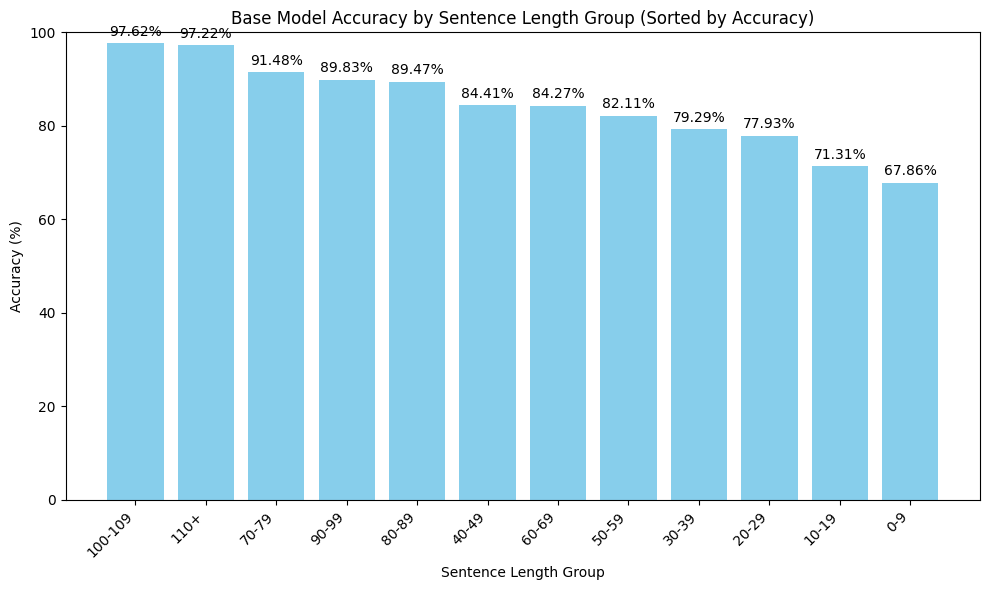

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get the length bin labels and accuracy values
labels = list(new_length_group_accuracy.keys())
accuracy_values = list(new_length_group_accuracy.values())

# Sort the labels and accuracy values based on accuracy in descending order
sorted_indices = np.argsort(accuracy_values)[::-1]
sorted_labels = [labels[i] for i in sorted_indices]
sorted_accuracy_values = [accuracy_values[i] for i in sorted_indices]

# Create a bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(sorted_labels, sorted_accuracy_values, color='skyblue')

# Add the accuracy values on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.2f}%', ha='center', va='bottom')

# Set the title and labels
ax.set_title('Base Model Accuracy by Sentence Length Group (Sorted by Accuracy)')
ax.set_xlabel('Sentence Length Group')
ax.set_ylabel('Accuracy (%)')
ax.set_ylim(0, 100) # Set y-axis limit from 0 to 100

# Rotate x-axis labels for better readability if needed
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()

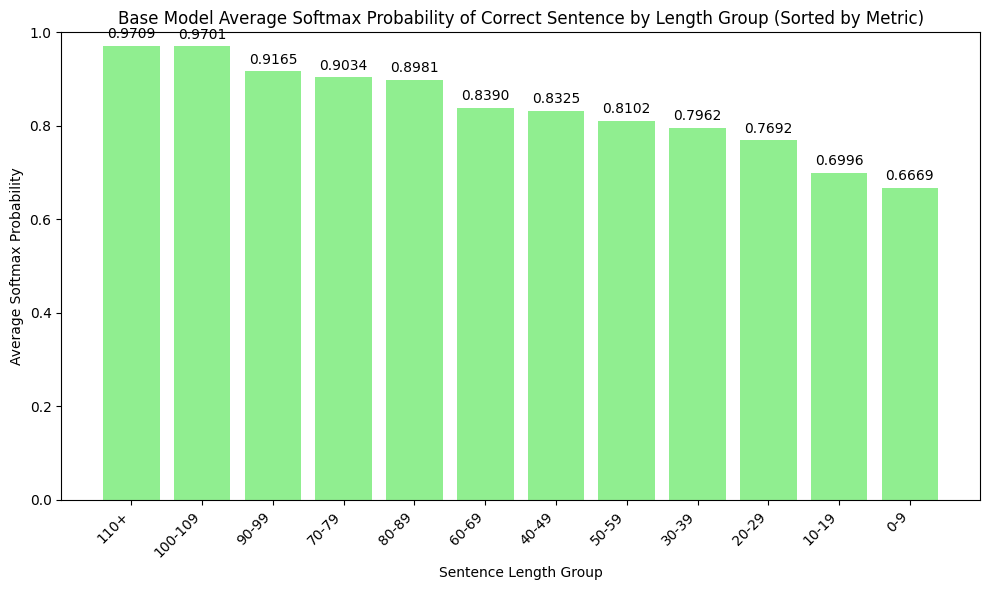

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get the length bin labels and average softmax probability values
labels = list(new_length_group_metric.keys())
metric_values = list(new_length_group_metric.values())

# Sort the labels and metric values based on metric in descending order
sorted_indices = np.argsort(metric_values)[::-1]
sorted_labels = [labels[i] for i in sorted_indices]
sorted_metric_values = [metric_values[i] for i in sorted_indices]

# Create a bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(sorted_labels, sorted_metric_values, color='lightgreen')

# Add the metric values on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.4f}', ha='center', va='bottom') # Adjusted vertical offset and format

# Set the title and labels
ax.set_title('Base Model Average Softmax Probability of Correct Sentence by Length Group (Sorted by Metric)')
ax.set_xlabel('Sentence Length Group')
ax.set_ylabel('Average Softmax Probability')
ax.set_ylim(0, 1) # Set y-axis limit from 0 to 1 for probabilities

# Rotate x-axis labels for better readability if needed
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()

# Calculate Overall Accuracy

In [ ]:
print("Calculating overall accuracy on the test dataset...")

correct_predictions_overall = 0
total_pairs_overall = len(test_pairs)

if total_pairs_overall > 0:
    for correct_item, ungrammatical_item in tqdm.tqdm(test_pairs, desc="Evaluating overall accuracy"):
        correct_sample = GrammarCheckDataset([correct_item], tokenizer)[0]
        ungrammatical_sample = GrammarCheckDataset([ungrammatical_item], tokenizer)[0]

        # Calculate total log probabilities
        prob_correct = get_sample_logprob(correct_sample, model)
        prob_ungrammatical = get_sample_logprob(ungrammatical_sample, model)

        # Check if the model predicted correctly
        if prob_correct > prob_ungrammatical:
            correct_predictions_overall += 1

    # Calculate overall accuracy
    overall_accuracy = (correct_predictions_overall / total_pairs_overall) * 100
    print(f"\nOverall Accuracy on Test Dataset: {overall_accuracy:.2f}% ({correct_predictions_overall}/{total_pairs_overall})")

Calculating overall accuracy on the test dataset...


Evaluating overall accuracy: 100%|██████████| 4149/4149 [08:42<00:00,  7.95it/s]


Overall Accuracy on Test Dataset: 78.69% (3265/4149)
Overall Normalized Accuracy on Test Dataset: 78.69%
